### Supervised Image, Audio and CentralNet benchmark

This notebook runs the centralnet benchmark as described in the CentralNet paper.
It assumes a ``data/avmnist/`` folder in the root with inside of it:
- an ``audio/`` folder with ``train_data_augmented_burst_noise.npy`` and ``test_data_augmented_burst_noise.npy`` created by audio_gen.ipynb notebook
- an ``image/`` folder with ``train_data.npy`` and ``test_data.npy`` 
- and a ``train_labels.npy`` and ``test_labels.npy`` 

The audio data created by the audio_gen.ipynb and the image and labels both acquired from: (https://github.com/pliang279/MultiBench?tab=readme-ov-file#multimedia, more specifically: https://drive.google.com/file/d/1KvKynJJca5tDtI5Mmp6CoRh9pQywH8Xp/view?usp=sharing)

In [ ]:
%load_ext autoreload
%autoreload 2
from utils.reproducibility import set_seed
set_seed(1)
import torch
import numpy as np
import sys
import os
from models.unimodal import CentralUnimodalImage, CentralUnimodalAudio
import torch.nn as nn
from utils.get_data import AVMNISTDataModule
from training_structures.unimodal import train as unimodal_train, test as unimodal_test
from models.centralnet.centralnet import SimpleAV_CentralNet as CentralNet
from training_structures.centralnet_train import train_centralnet, test_centralnet
from utils.visualisations import show_images, pca_plot_multiclass, tsne_plot_multiclass, pca_plot_dataloaders
# torch.multiprocessing.set_start_method('spawn')

current_path = os.getcwd()
sys.path.append(current_path)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
data_dir = os.path.join(current_path, "data/avmnist/")
dir_logs = os.path.join(current_path, "supervised_results/")

c:\Users\Ward\anaconda3\envs\multibench\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Initialize Dataloaders

In [2]:
mnist_data = AVMNISTDataModule(data_dir=data_dir, batch_size=128, num_workers=0)
mnist_data.setup()
traindata, _, testdata = mnist_data.train_dataloader(), mnist_data.val_dataloader(), mnist_data.test_dataloader()

Batch of images | image: torch.Size([128, 1, 28, 28]) | audio: torch.Size([128, 1, 112, 112]) | label: torch.Size([128])


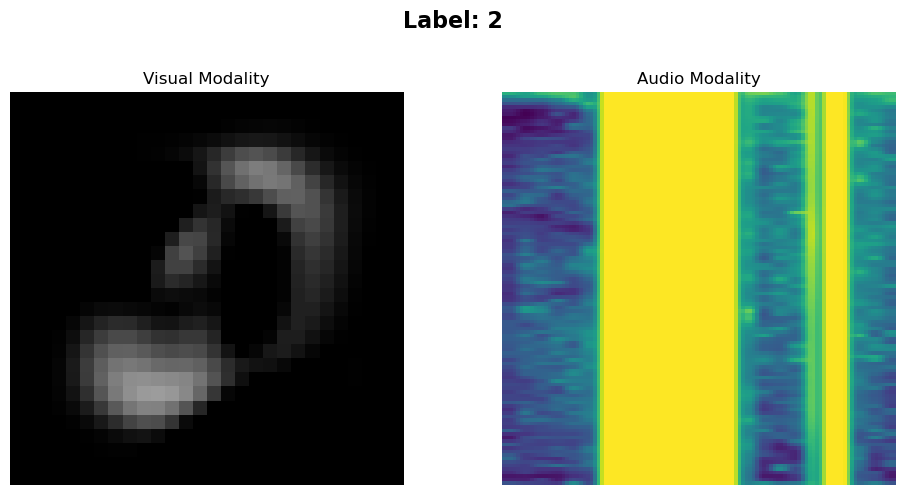

In [3]:
for image, audio, label in traindata:
    print(f"Batch of images | image: {image.shape} | audio: {audio.shape} | label: {label.shape}")
    show_images(image[1], audio[1], label[1], save_path=None)
    break  # Test one batch

#### Hyperparameter settings

In [4]:
class Args_Unimodal:
    def __init__(self):
        self.criterion = nn.CrossEntropyLoss() # Loss function
        self.use_cuda = torch.cuda.is_available()  # Use GPU if available
        self.learning_rate = 0.001 # Initial learning rate
        self.batch_size = 128       # Batch size
        self.epochs = 100          # Total training epochs

In [5]:
class Args_CentralNet:
    def __init__(self):
        self.channels = 16         # Base convolution channels
        self.fusingmix = '11,32,53' # Fusion strategy
        self.fusetype = 'wsum'     # Weighted sum fusion
        self.num_outputs = 10      # Number of classes (AVMNIST)
        self.criterion = nn.CrossEntropyLoss() # Loss function
        self.use_cuda = torch.cuda.is_available()  # Use GPU if available
        self.learning_rate = 0.001 # Initial learning rate
        self.batch_size = 128       # Batch size
        self.epochs = 100          # Total training epochs

#### Training and Plotting functions

In [6]:
def train_supervised_model(model, args, device, is_unimodal=False, modalnum=0):
    """
    Train a supervised model (either unimodal or centralnet)

    Args:
        model: The model to train
        args: Arguments for training
        device: Device to use (CPU or GPU)
        is_unimodal: Whether the model is unimodal or centralnet
        modalnum: The index of the unimodal data (0 for image, 1 for audio)
    """
    if is_unimodal==False:
        model_type = "centralnet"
    elif is_unimodal==True and modalnum==0:
        model_type = "image"
    elif is_unimodal==True and modalnum==1:
        model_type = "audio"
    
    print(f"Training {model_type}")

    dir_model = os.path.join(dir_logs, f"{model_type}/")

    for path in [dir_model]:
        if not os.path.exists(path):
            os.makedirs(path)

    seeds = [1, 2, 3]
    test_accuracies = []
    for seed in seeds:
        print(f"Running seed: {seed}")
        set_seed(seed)

        model_name = f'{dir_model}model_{model_type}_seed_{seed}.pt'
        train_log_file = f"{dir_model}training_log_{model_type}_seed_{seed}.csv"
        test_log_file = f"{dir_model}test_results_{model_type}_seed_{seed}.csv"

        if is_unimodal:
            model_name = unimodal_train(model, args, traindata, device, modalnum=modalnum, 
                                        log_file=train_log_file, save_model=model_name)
        else:
            model_name = train_centralnet(model, args, traindata, device,
                                        log_file=train_log_file, save_model=model_name)

        print(f"Testing {model_type}")

        if is_unimodal:
            _, accuracy, _, _ = unimodal_test(model, testdata, args.criterion, device, 
                                                modalnum=modalnum, test_log_file=test_log_file)
        else:
            _, accuracy, _, _ = test_centralnet(model, testdata, args.criterion, device, 
                                                test_log_file=test_log_file)
            
        test_accuracies.append(accuracy)

    # Final summary
    mean_acc = np.mean(test_accuracies)
    std_acc = np.std(test_accuracies)
    mean_string = f"Mean Test Accuracy over {len(seeds)} seeds: {mean_acc:.4f}"
    std_string = f"Std Dev of Accuracy: {std_acc:.4f}"
    summary_path = os.path.join(dir_model, "accuracy_summary.txt")

    print(mean_string)
    print(std_string)

    # Open and write the summary
    with open(summary_path, "w") as f:
        f.write(f"{mean_string}\n")
        f.write(f"{std_string}\n")

In [7]:
def plot_dimensionality_reduction(model, plot_path):
    _ = pca_plot_dataloaders(model, testdata, selected_digits=[5, 8], dirpath=plot_path, 
                            show_plots=False, is_dino_based=False)
    _ = pca_plot_multiclass(model, testdata, selected_digits=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 
                            dirpath=plot_path, show_plots=False, is_dino_based=False)
    _ = tsne_plot_multiclass(model, testdata, selected_digits=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 
                            dirpath=plot_path, show_plots=False, random_seed=0, is_dino_based=False)

#### Unimodal Image

In [ ]:
args_image = Args_Unimodal()
model_image = CentralUnimodalImage(with_head=True).to(device)
train_supervised_model(model_image, args_image, device, is_unimodal=True, modalnum=0)

Training image
Running seed: 1


Training Epochs: 100%|██████████| 100/100 [14:28<00:00,  8.69s/it, loss=0.7513]


Training Complete!
Testing image


Testing: 100%|██████████| 79/79 [00:02<00:00, 27.05it/s]


Test Loss: 0.9506, Test Accuracy: 64.71%
Running seed: 2


Training Epochs: 100%|██████████| 100/100 [14:18<00:00,  8.58s/it, loss=0.6507]


Training Complete!
Testing image


Testing: 100%|██████████| 79/79 [00:02<00:00, 26.60it/s]


Test Loss: 1.1885, Test Accuracy: 63.44%
Running seed: 3


Training Epochs: 100%|██████████| 100/100 [13:54<00:00,  8.35s/it, loss=0.5870]


Training Complete!
Testing image


Testing: 100%|██████████| 79/79 [00:02<00:00, 27.67it/s]

Test Loss: 1.4752, Test Accuracy: 63.23%
Mean Test Accuracy over 3 seeds: 63.7933
Std Dev of Accuracy: 0.6538


In [9]:
class ImageWrapper(nn.Module):
    """
    Since centralnet returns image_out, audio_out, fusion_out, 
    we need to wrap it to only return the fusion_out. Since this is what we want to visualize.
    """
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model

    def forward(self, image, audio):
        out = self.base_model(image) # Assuming the model takes audio first and then image
        return out

image_wrapper = ImageWrapper(model_image)
plot_dimensionality_reduction(image_wrapper, os.path.join(dir_logs, "image", "plots"))

100%|██████████| 79/79 [00:01<00:00, 61.91it/s]


Selected digits for visualization: [5, 8]


100%|██████████| 79/79 [00:01<00:00, 61.24it/s]


Visualizing digits: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


100%|██████████| 79/79 [00:01<00:00, 62.95it/s]
c:\Users\Ward\anaconda3\envs\multibench\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Visualizing digits: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Applying t-SNE...


#### Unimodal Audio

In [10]:
args_audio = Args_Unimodal()
model_audio = CentralUnimodalAudio(with_head=True).to(device)
train_supervised_model(model_audio, args_audio, device, is_unimodal=True, modalnum=1)

Training audio
Running seed: 1


Training Epochs: 100%|██████████| 100/100 [26:05<00:00, 15.65s/it, loss=0.0129]


Training Complete!
Testing audio


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.60it/s]


Test Loss: 0.7108, Test Accuracy: 90.74%
Running seed: 2


Training Epochs: 100%|██████████| 100/100 [26:07<00:00, 15.68s/it, loss=0.0076]


Training Complete!
Testing audio


Testing: 100%|██████████| 79/79 [00:03<00:00, 22.83it/s]


Test Loss: 0.9300, Test Accuracy: 90.41%
Running seed: 3


Training Epochs: 100%|██████████| 100/100 [26:29<00:00, 15.89s/it, loss=0.0067]


Training Complete!
Testing audio


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.36it/s]

Test Loss: 1.1643, Test Accuracy: 90.30%
Mean Test Accuracy over 3 seeds: 90.4833
Std Dev of Accuracy: 0.1870


In [11]:
class AudioWrapper(nn.Module):
    """
    Since centralnet returns image_out, audio_out, fusion_out, 
    we need to wrap it to only return the fusion_out. This is what we want to visualize.
    """
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model

    def forward(self, image, audio):
        out = self.base_model(audio) # Assuming the model takes audio first and then image
        return out

audio_wrapper = AudioWrapper(model_audio)
plot_dimensionality_reduction(audio_wrapper, os.path.join(dir_logs, "audio", "plots"))

100%|██████████| 79/79 [00:01<00:00, 67.75it/s]


Selected digits for visualization: [5, 8]


100%|██████████| 79/79 [00:01<00:00, 65.83it/s]


Visualizing digits: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


100%|██████████| 79/79 [00:01<00:00, 70.98it/s]
c:\Users\Ward\anaconda3\envs\multibench\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Visualizing digits: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Applying t-SNE...


#### Multimodal CentralNet

In [12]:
args_central = Args_CentralNet()
model_central = CentralNet(args_central, audio_channels=1, image_channels=1).to(device)
train_supervised_model(model_central, args_central, device, is_unimodal=False)  # Train centralnet model

Training centralnet
Running seed: 1


Training Epochs: 100%|██████████| 100/100 [34:17<00:00, 20.58s/it, loss=0.8134]


Training Complete!
Testing centralnet
Test Loss: 0.1513, Test Accuracy: 96.69%
Running seed: 2


Training Epochs: 100%|██████████| 100/100 [35:49<00:00, 21.50s/it, loss=0.7942]


Training Complete!
Testing centralnet
Test Loss: 0.1510, Test Accuracy: 96.80%
Running seed: 3


Training Epochs: 100%|██████████| 100/100 [36:14<00:00, 21.75s/it, loss=0.7791]


Training Complete!
Testing centralnet
Test Loss: 0.1786, Test Accuracy: 96.77%
Mean Test Accuracy over 3 seeds: 96.7533
Std Dev of Accuracy: 0.0464


In [13]:
class FusionOnlyWrapper(nn.Module):
    """
    Since centralnet returns image_out, audio_out, fusion_out, 
    we need to wrap it to only return the fusion_out. Since this is what we want to visualize.
    """
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model

    def forward(self, image, audio):
        _, _, fusion_out = self.base_model(audio, image) # Assuming the model takes audio first and then image
        return fusion_out

central_wrapper = FusionOnlyWrapper(model_central)
plot_dimensionality_reduction(central_wrapper, os.path.join(dir_logs, "centralnet", "plots"))

100%|██████████| 79/79 [00:01<00:00, 66.22it/s]


Selected digits for visualization: [5, 8]


100%|██████████| 79/79 [00:01<00:00, 66.11it/s]


Visualizing digits: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


100%|██████████| 79/79 [00:01<00:00, 69.04it/s]


Visualizing digits: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Applying t-SNE...


c:\Users\Ward\anaconda3\envs\multibench\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
